In [134]:
# Add project src to path.
import set_path
import glob

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils
import src.utils.bgt_utils as bgt_utils

from src.utils.interpolation import FastGridInterpolator

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks
from src.region_growing.label_connected_comp import LabelConnectedComp

from sklearn.metrics import classification_report

In [2]:
def plot_cloud(points, labels, plot_3d=True, legend=True, aspect=5):

    fig = plt.figure()
    if plot_3d:
        ax = plt.axes(projection='3d')
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1],points[mask][:,2], s=2, label=str(label))
        ax.set_zlim((0,12))
        if aspect:
            centers = points.min(axis=0) + ((points.max(axis=0) - points.min(axis=0)) / 2)
            ax.set_xlim((centers[0]-aspect,centers[0]+aspect))
            ax.set_ylim((centers[1]-aspect,centers[1]+aspect))

    else:
        ax = plt.axes()
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1], s=1,label=str(label))
    if legend:
        plt.legend()
    plt.show()

In [3]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    # Code
    # cable_mask = sample_cable(points, true_labels)
    # armatuur_extractor(points, cable_mask, true_labels)
    

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample6.laz
Processing file ../datasets/suspended_light_cables/sample7.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz
Processing file ../datasets/suspended_light_cables/sample9.laz
Processing file ../datasets/suspended_light_cables/sample8.laz
Processing file ../datasets/suspended_light_cables/sample10.laz
Processing file ../datasets/suspended_light_cables/sample11.laz


## Pipeline methods

In [4]:
def sample_cable(points, true_labels, sample_size=0.8):
    if sample_size == 1:
        return true_labels == 15
    else:
        cable_ids = np.where(true_labels==15)[0]
        cable_sample_ids = np.random.choice(cable_ids, int(len(cable_ids)*(1-sample_size)), replace=False)
        sample_labels = true_labels.copy()
        sample_labels[cable_sample_ids] = 0
        cable_mask = sample_labels == 15

        return cable_mask

In [5]:
def main_direction(points):
    """ Returns the eigenvector corresponding to the largest eigenvalue of `points`"""
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    if dir_v[0] < 0:
        dir_v *= -1
    return dir_v

def cable_cut(points, mask):
    """Create a new axis along the direction of a cable. Cable start is 0"""
    cable_dir = main_direction(points[mask][:,:2])
    cable_dir_axis = np.dot(points[:,:2], cable_dir)
    cable_dir_axis -= cable_dir_axis[mask].min()
    return cable_dir_axis

def cable_to_linestrings(points, cable_axis):

    # start and end points
    start_idx = cable_axis.argmin()
    start_pt = [points[start_idx,0], points[start_idx,1]]
    end_idx = cable_axis.argmax()
    end_pt = [points[end_idx,0], points[end_idx,1]]
    
    # cable height LineString (along direction)
    point_spacing = 0.5
    mean_z, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 2], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    xs = np.arange((point_spacing/2), cable_axis.max() - (point_spacing/2), point_spacing)
    line_pts = np.vstack((xs, mean_z)).T
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_ylinestring = shapely.geometry.LineString(line_pts)

    # cable planar LineString
    point_spacing = 1
    mean_x, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 0], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    mean_y, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 1], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    line_pts = np.vstack((mean_x, mean_y)).T
    line_pts = np.vstack((line_pts, start_pt, end_pt))
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_axislinestring = shapely.geometry.LineString(line_pts)

    return cable_ylinestring, cable_axislinestring

def clip_cable_area(points, mask, cable_axis, h_buffer=0.5, w_buffer=.5):

    # Cable directional and height line
    cable_yline, cable_axisline = cable_to_linestrings(points[mask], cable_axis[mask])

    # Height clip
    cable_ypoly = cable_yline.buffer(h_buffer)
    dir_points = np.vstack((cable_axis, points[:,2])).T
    height_clip_mask = clip_utils.poly_clip(dir_points, cable_ypoly)

    # Direction clip
    cable_axispoly = cable_axisline.buffer(w_buffer)
    axis_clip_mask = clip_utils.poly_clip(points[:,:2], cable_axispoly)

    # Clip
    clip_mask = np.logical_and(height_clip_mask, axis_clip_mask)

    return clip_mask, cable_yline, cable_axisline


In [136]:
def projection_filter(points, cable_axis, plot=True, num_dil=3):

    # Project
    grid, _, _, binnumber = scipy.stats.binned_statistic_2d(cable_axis, points[:,2], np.ones(len(points)), statistic='count', bins=[np.arange(cable_axis.min(), cable_axis.max(), 0.05), np.arange(points[:,2].min(), points[:,2].max(), 0.05)], expand_binnumbers=True)
    grid_shape = np.array(grid.shape) + 1
    binindices = np.ravel_multi_index(binnumber-1, grid_shape)

    # Image filters
    grid = np.where(grid>0, True, False)
    grid_1 = ndimage.binary_fill_holes(grid)
    grid_2 = ndimage.binary_erosion(grid_1, iterations=2)
    grid_3 = ndimage.binary_dilation(grid_2, iterations=num_dil)

    if plot:
        fig, ax = plt.subplots(4,1, sharex=True)
        ax[0].imshow(grid.T, cmap = 'gray')
        ax[1].imshow(grid_1.T, cmap = 'gray')
        ax[2].imshow(grid_2.T, cmap = 'gray')
        ax[3].imshow(grid_3.T, cmap = 'gray')
        ax[0].invert_yaxis()
        ax[1].invert_yaxis()
        ax[2].invert_yaxis()
        ax[3].invert_yaxis()

    # convert 2d back to 3d mask
    multi_index = np.array(np.where(grid_3>0))
    residual_bins = np.ravel_multi_index(multi_index, grid_shape)
    residual_mask = np.isin(binindices, residual_bins)

    return residual_mask

def segmentation_plot(points, cable_axis, segmentation, filter_mask, cable_yline):

    # Plot clusters
    fig = plt.figure()
    ax = plt.axes()
    for cluster in np.unique(segmentation.labels_):
        c_mask = segmentation.labels_ == cluster
        ax.scatter(cable_axis[filter_mask][c_mask], points[filter_mask][c_mask][:,2], s=1)
        ax.scatter(cable_axis[filter_mask][c_mask].mean(), points[filter_mask][c_mask][:,2].mean(), c='k')
    #ax.scatter(cable_axis[filter_mask], points[filter_mask][:,2], s=1)
    ax.scatter(cable_axis[~filter_mask], points[~filter_mask][:,2], s=1, c='gray')

    yline = np.array(cable_yline.coords)
    ax.plot(yline[:,0], yline[:,1], c='k')

    ax.set_ylim((points[:,2].min()-1,points[:,2].max()+1))

def _is_armatuur(points, cable_axis, cable_yline, cable_axisline):

    # Cluster dimension
    cl_width = cable_axis.max() - cable_axis.min()
    cl_height = points[:,2].max() - points[:,2].min()

    # Cluster position offset
    cl_centroid = points.mean(axis=0)
    axis_coord = cable_axis.mean()
    y_offset = nearest_points(cable_yline, Point([axis_coord, cl_centroid[2]]))[0].y - cl_centroid[2]
    axis_offset = LineString(nearest_points(cable_axisline, Point(cl_centroid[:2]))).length

    # Check conditions (1. cluster dimensions & 2. centroid should be under cable)
    width_cond = .25 < cl_width < 1
    height_cond = .2 < cl_height < .55
    yoff_cond = 0 < y_offset < .55
    xyoff_cond = axis_offset < 0.1
    valid_cluster = np.all([width_cond, height_cond, yoff_cond, xyoff_cond])

    record = [axis_coord, cl_width, cl_height, y_offset, axis_offset, valid_cluster]

    return valid_cluster, record

def armatuur_extractor(points, cable_mask, true_labels, plot=False):

    # 0. create mask
    armatuur_mask = np.zeros(len(points), dtype=bool)
    label_mask = np.zeros(len(points))
    label_mask[true_labels==15] = 15

    # 1. Clip search-area
    cable_axis = cable_cut(points, cable_mask)
    clip_mask, cable_yline, cable_axisline = clip_cable_area(points, cable_mask, cable_axis)
    
    #plot_cloud(points[clip_mask], true_labels[clip_mask])

    # 2. Projection
    filter_mask = projection_filter(points[clip_mask], cable_axis[clip_mask], plot, 5)

    # 3. ConnectedComponents
    filter_mask = ~cable_mask[np.where(clip_mask)[0]] & filter_mask

    lcc = LabelConnectedComp(grid_size=0.1, min_component_size=20)
    point_components = lcc.get_components(points[clip_mask][filter_mask])
    cc_labels = np.unique(point_components)

    # 3. Cluster analysis for armatuur
    cc_count = 0
    for cc in set(cc_labels).difference((-1,)):
        # select points that belong to the cluster
        cc_mask = (point_components == cc)
        cc_pts = points[clip_mask][filter_mask][cc_mask]
        cc_axis_pts = cable_axis[clip_mask][filter_mask][cc_mask]
        valid, _ = _is_armatuur(cc_pts, cc_axis_pts, cable_yline, cable_axisline)
        if valid:
            armatuur_mask[np.where(clip_mask)[0][filter_mask][cc_mask]] = valid

    if plot:
        plot_cloud(points[clip_mask], armatuur_mask[clip_mask])

    return armatuur_mask, clip_mask



In [139]:
las_file = '../datasets/suspended_light_cables/sample1.laz'
pointcloud = las_utils.read_las(las_file)
true_labels = pointcloud.label
true_labels[~((true_labels == 15) | (true_labels == 14))] = 0
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = np.zeros(len(points))

# Sample cable mask?
cable_mask = sample_cable(points, true_labels, 1)
armatuur_mask, clip_mask = armatuur_extractor(points, cable_mask, true_labels, True)

label_mask = np.zeros(len(points))
label_mask[true_labels==15] = 15
label_mask[armatuur_mask] = 14
classification_report(true_labels[clip_mask], label_mask[clip_mask], labels=[0,14,15], target_names=['unclassified', 'armatuur', 'cable'], output_dict=True, zero_division=1)['armatuur']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 0.995475113122172,
 'recall': 0.9401709401709402,
 'f1-score': 0.967032967032967,
 'support': 234}

In [135]:
results = []

for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):

    print('Processing file', las_file)
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    true_labels[~((true_labels == 15) | (true_labels == 14))] = 0
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    # Sample cable mask?
    cable_mask = sample_cable(points, true_labels, 1)

    armatuur_mask, clip_mask = armatuur_extractor(points, cable_mask, true_labels, True)

    label_mask = np.zeros(len(points))
    label_mask[true_labels==15] = 15
    label_mask[armatuur_mask] = 14
    report = classification_report(true_labels[clip_mask], label_mask[clip_mask], labels=[0,14,15], target_names=['unclassified', 'armatuur', 'cable'], output_dict=True, zero_division=1)['armatuur']
    print(report)
    results.append(report)

df = pd.DataFrame(results)[['precision','recall','f1-score']]
df.boxplot()
df.mean()

Processing file ../datasets/suspended_light_cables/sample1.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 0.9950980392156863, 'recall': 0.8675213675213675, 'f1-score': 0.9269406392694064, 'support': 234}
Processing file ../datasets/suspended_light_cables/sample3.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 986}
Processing file ../datasets/suspended_light_cables/sample2.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1149}
Processing file ../datasets/suspended_light_cables/sample6.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 0}
Processing file ../datasets/suspended_light_cables/sample7.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 0}
Processing file ../datasets/suspended_light_cables/sample5.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 0.9845559845559846, 'f1-score': 0.9922178988326849, 'support': 518}
Processing file ../datasets/suspended_light_cables/sample4.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 0.9886104783599089, 'f1-score': 0.9942726231386024, 'support': 439}
Processing file ../datasets/suspended_light_cables/sample9.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 0.9942196531791907, 'f1-score': 0.9971014492753623, 'support': 865}
Processing file ../datasets/suspended_light_cables/sample8.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 0.0, 'recall': 1.0, 'f1-score': 0.0, 'support': 0}
Processing file ../datasets/suspended_light_cables/sample10.laz


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 0}
Processing file ../datasets/suspended_light_cables/sample11.laz


/var/folders/1p/z114bvjj7r59fvq3rbdcg3c40000gn/T/ipykernel_5281/1135524194.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(4,1, sharex=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'precision': 1.0, 'recall': 0.9968553459119497, 'f1-score': 0.9984251968503937, 'support': 318}


precision    0.908645
recall       0.984706
f1-score     0.900814
dtype: float64

## Approach: LCC

In [128]:
def armatuur_extractor_cc(points, cable_mask, plot=False):

    # 0. create mask
    armatuur_mask = np.zeros(len(points), dtype=bool)

    # 1. Clip search-area
    cable_axis = cable_cut(points, cable_mask)
    clip_mask, cable_yline, cable_axisline = clip_cable_area(points, cable_mask, cable_axis, 1, .5)

    # 2. ConnectedComponents
    mask = clip_mask & ~cable_mask
    lcc = LabelConnectedComp(label=0, grid_size=0.1,
                            min_component_size=20)
    point_components = lcc.get_components(points[mask])
    cc_labels = np.unique(point_components)

    # 3. Cluster analysis for armatuur
    cc_count = 0
    for cc in set(cc_labels).difference((-1,)):
        # select points that belong to the cluster
        cc_mask = (point_components == cc)

        cc_pts = points[mask][cc_mask]
        cc_axis_pts = cable_axis[mask][cc_mask]

        valid, _ = _is_armatuur(cc_pts, cc_axis_pts, cable_yline, cable_axisline)
        if valid:
            armatuur_mask[np.where(mask)[0][cc_mask]] = True
            cc_count += 1

    if plot:
        # plot_cloud(points[mask], point_components)
        plot_cloud(points[mask], armatuur_mask[mask])
        
    return armatuur_mask, clip_mask

In [115]:
pointcloud = las_utils.read_las('../datasets/suspended_light_cables/sample7.laz')
true_labels = pointcloud.label
true_labels[~((true_labels == 15) | (true_labels == 14))] = 0
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = np.zeros(len(points))

cable_mask = sample_cable(points, true_labels, 1)
armatuur_mask, clip_mask, = armatuur_extractor_cc(points, cable_mask, False)
label_mask = np.zeros(len(points))
label_mask[true_labels==15] = 15
label_mask[armatuur_mask] = 14

classification_report(true_labels[clip_mask], label_mask[clip_mask], labels=[0,14,15], target_names=['unclassified', 'armatuur', 'cable'], output_dict=True, zero_division=1)['armatuur']

{'precision': 0.0, 'recall': 1.0, 'f1-score': 0.0, 'support': 0}

precision    0.908704
recall       0.999379
f1-score     0.908585
dtype: float64

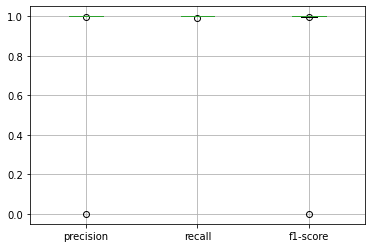

In [131]:
results = []

for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):

    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    true_labels[~((true_labels == 15) | (true_labels == 14))] = 0
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    # armatuur_extractor_cc
    cable_mask = sample_cable(points, true_labels, 1)
    armatuur_mask, clip_mask = armatuur_extractor_cc(points, cable_mask, False)

    label_mask = np.zeros(len(points))
    label_mask[true_labels==15] = 15
    label_mask[armatuur_mask] = 14
    report = classification_report(true_labels[clip_mask], label_mask[clip_mask], labels=[0,14,15], target_names=['unclassified', 'armatuur', 'cable'], output_dict=True, zero_division=1)['armatuur']
    # print('Processing file', las_file, '\tf1-scocre:',report['f1-score'])
    results.append(report)

df = pd.DataFrame(results)[['precision','recall','f1-score']]
df.boxplot()
df.mean()

## Aproach:
Cable-density


In [11]:
def cable_density(points, labels, plot=True):

    # Projection axis
    cable_mask = labels == 15
    cable_dir_axis = cable_cut(points, cable_mask)

    res = scipy.stats.binned_statistic(cable_dir_axis, np.ones(len(points)), statistic='count', bins=int(cable_dir_axis.max()/0.1))
    x = (res.bin_edges[:-1]+res.bin_edges[1:])/2
    y = res.statistic / len(points)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(x, y)

Processing file ../datasets/suspended_light_cables/sample1.laz


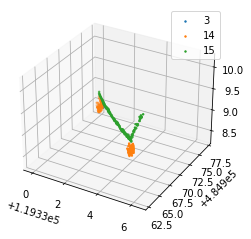

Processing file ../datasets/suspended_light_cables/sample3.laz


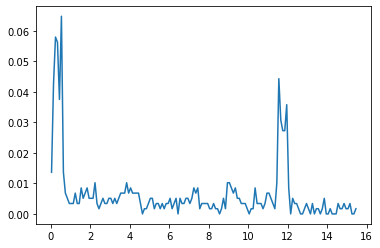

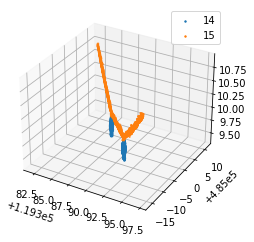

Processing file ../datasets/suspended_light_cables/sample2.laz


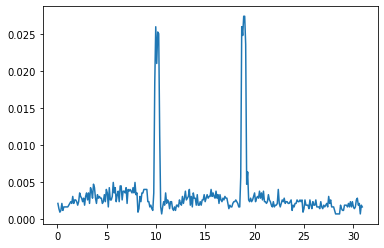

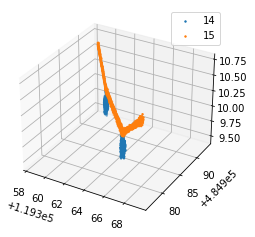

Processing file ../datasets/suspended_light_cables/sample5.laz


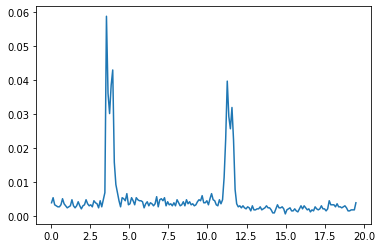

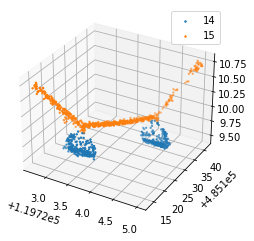

Processing file ../datasets/suspended_light_cables/sample4.laz


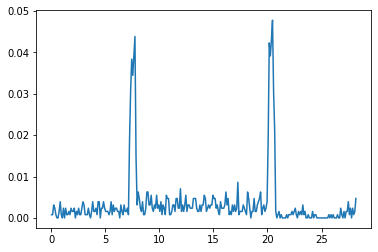

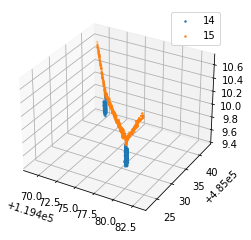

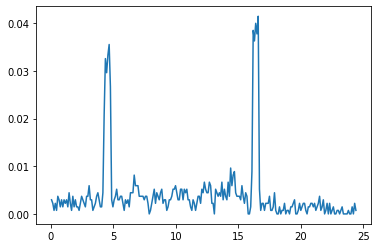

In [342]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    plot_cloud(points, true_labels)
    cable_density(points, true_labels)

## Approach: 
Cable-bending

In [9]:
def unit_vector(v1):
    """ Returns the unit vector of `v1`"""
    return v1 / np.linalg.norm(v1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [10]:
def cable_angle(points, labels, plot=True):

    cable_mask = labels == 15
    lamp_mask = labels == 14

    # Calculate directional axis
    cable_dir_axis = cable_cut(points, cable_mask)

    # cable height LineString (along direction)
    mean_z, _, _ = scipy.stats.binned_statistic(cable_dir_axis[cable_mask], points[cable_mask][:, 2], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 0.5))
    xs = np.arange(0.25, cable_dir_axis.max()-0.25, 0.5)
    ls_poitns = np.vstack((xs, mean_z)).T
    cable_height_linestring = shapely.geometry.LineString(ls_poitns)

    # Calculate angle change
    color_v = []
    for i in range(len(ls_poitns)):
        if i < 5 or i > len(ls_poitns) - 6:
            color_v.append(0.)
        else:
            v_a = ls_poitns[i] - ls_poitns[i-5]
            v_b = ls_poitns[i+5] - ls_poitns[i]
            angle = angle_between(v_a, v_b)
            color_v.append(angle)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(xs, mean_z, s=4, c=color_v, cmap='Reds_r')
        ax.scatter(cable_dir_axis[lamp_mask], points[lamp_mask,2], s=2)

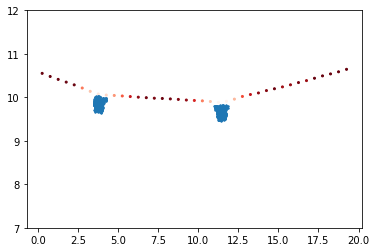

In [337]:
cable_angle(points, true_labels)

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz


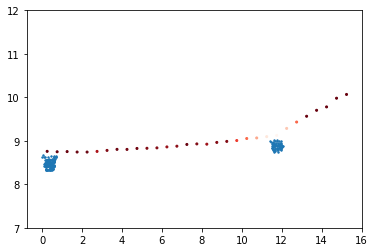

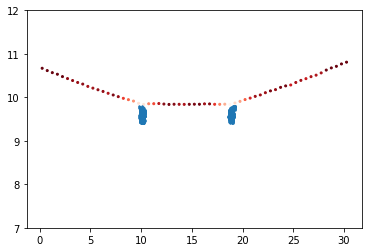

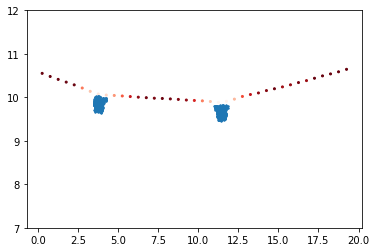

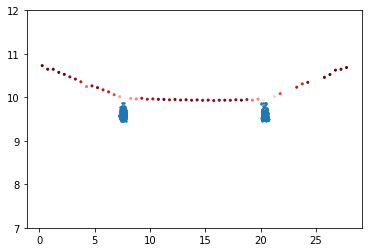

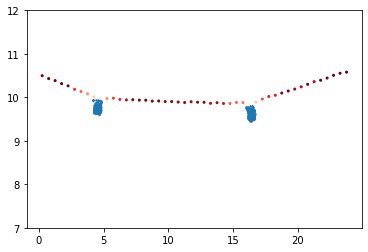

In [338]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    cable_angle(points, true_labels)